# **FIRST WE BEGIN WITH ALL THE INSTALLATIONS**

In [1]:
!pip install openpyxl
!pip install transformers
!pip install pandas
!pip install img2table

   ---------------------------------------- 90.2/90.2 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 28.8/28.8 MB 10.9 MB/s eta 0:00:00
   ---------------------------------------- 3.2/3.2 MB 11.3 MB/s eta 0:00:00
   ---------------------------------------- 12.4/12.4 MB 11.7 MB/s eta 0:00:00
   ---------------------------------------- 159.9/159.9 kB 9.4 MB/s eta 0:00:00
   ---------------------------------------- 45.5/45.5 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: xlsxwriter
    Found existing installation: XlsxWriter 3.0.3
    Uninstalling XlsxWriter-3.0.3:
      Successfully uninstalled XlsxWriter-3.0.3


# **NEXT, ALL THE IMPORTS**

In [2]:
import cv2
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import Workbook
from openpyxl.utils import get_column_letter
from PIL import Image as PILImage
from img2table.document import Image as Img2TableImage

# **ENTER THE FILEPATH:**

In [7]:
filepath="" #enter image path here

# **NOW WE WILL VISUALIZE THE TABLE DETECTION**

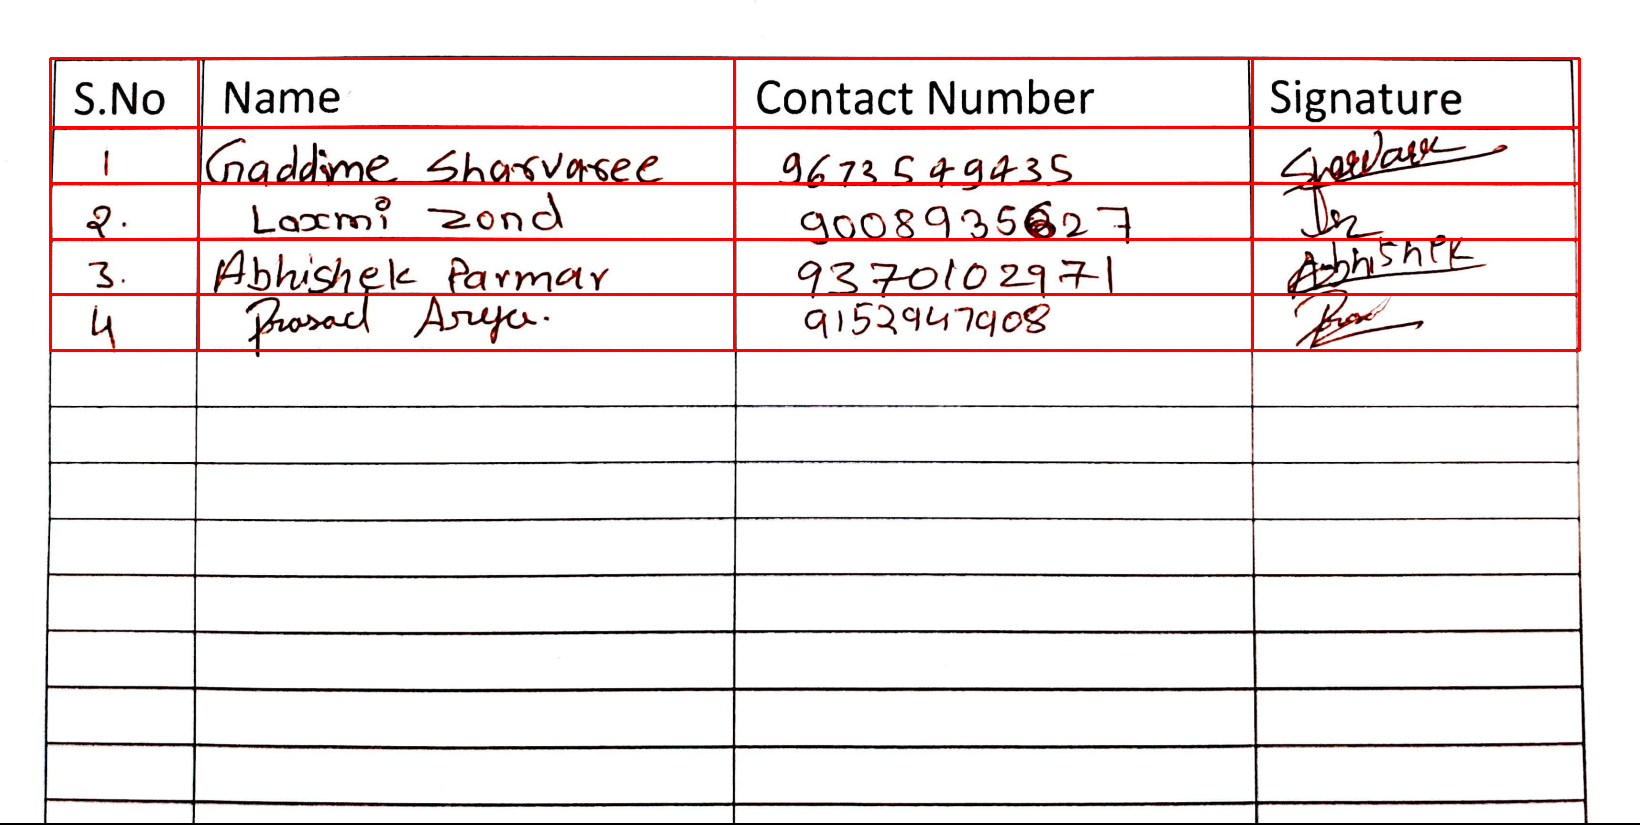

In [5]:
img = Img2TableImage(src=filepath)

# Extract tables
extracted_tables = img.extract_tables()

# Display extracted tables
table_img = cv2.imread(filepath)

for table in extracted_tables:
    for row in table.content.values():
        for cell in row:
            cv2.rectangle(table_img, (cell.bbox.x1, cell.bbox.y1), (cell.bbox.x2, cell.bbox.y2), (255, 0, 0), 2)

PILImage.fromarray(table_img)

# **LASTLY, WE ENTER THESE ENTRIES INTO AN EXCEL SHEET**

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Table 1:


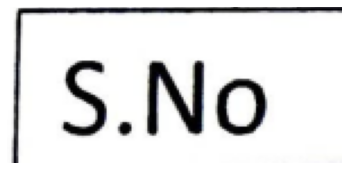

Table 1, Row 1, Column 1: is no


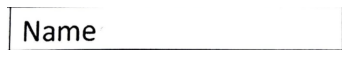

Table 1, Row 1, Column 2: Name.


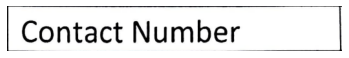

Table 1, Row 1, Column 3: Contact Number 2


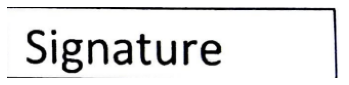

Table 1, Row 1, Column 4: signature.


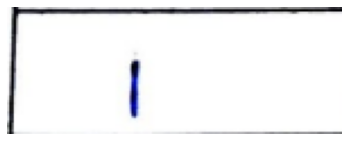

Table 1, Row 2, Column 1: Mr.


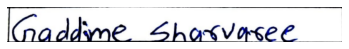

Table 1, Row 2, Column 2: Knaddome Sharsvarsee


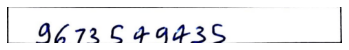

Table 1, Row 2, Column 3: 9673549435


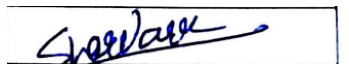

Table 1, Row 2, Column 4: crossless.


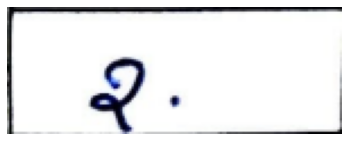

Table 1, Row 3, Column 1: sp.


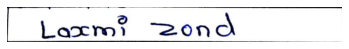

Table 1, Row 3, Column 2: Laxmi zond


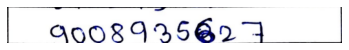

Table 1, Row 3, Column 3: ( 900893502 7


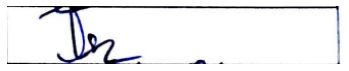

Table 1, Row 3, Column 4: Don't


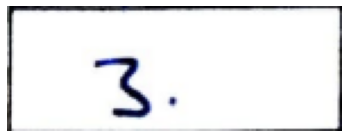

Table 1, Row 4, Column 1: 3. 3.


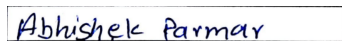

Table 1, Row 4, Column 2: Abhishek Parmar


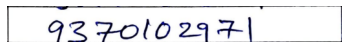

Table 1, Row 4, Column 3: 93 70102971.


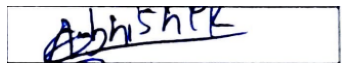

Table 1, Row 4, Column 4: goblisher.


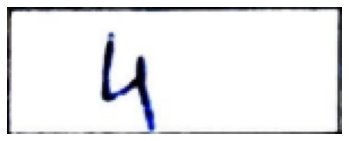

Table 1, Row 5, Column 1: 14 1


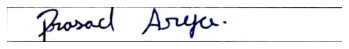

Table 1, Row 5, Column 2: Phosack Arveyon.


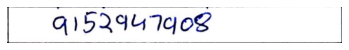

Table 1, Row 5, Column 3: ( 915294798808


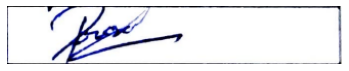

Table 1, Row 5, Column 4: Road -
Excel file saved as 'finaloutput.xlsx'.


In [9]:
def initialize_trocr_model():
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
    model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
    return processor, model

def extract_tables_from_image(image_path):
    img = Img2TableImage(src=image_path)
    extracted_tables = img.extract_tables()
    return extracted_tables

def recognize_text_in_cell(cell_image, processor, model):
    # Convert cell_image to PIL image
    pil_image = PILImage.fromarray(cv2.cvtColor(cell_image, cv2.COLOR_BGR2RGB))

    # Prepare the image for the model
    pixel_values = processor(images=pil_image, return_tensors="pt").pixel_values

    # Generate text
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

def main():
    # Initialize TrOCR model and processor
    processor, model = initialize_trocr_model()

    extracted_tables = extract_tables_from_image(filepath)

    # Create an Excel workbook and sheet
    wb = Workbook()
    ws = wb.active

    # Process each table
    for table_idx, table in enumerate(extracted_tables):
        print(f"Table {table_idx + 1}:")
        for id_row, row in enumerate(table.content.values(), start=1):
            for id_col, cell in enumerate(row, start=1):
                x1 = cell.bbox.x1
                y1 = cell.bbox.y1
                x2 = cell.bbox.x2
                y2 = cell.bbox.y2

                # Load the entire table image (optional for display)
                #table_image = cv2.imread(filepath)

                # Crop the cell region from the table image
                cell_image = cv2.imread(filepath)[y1:y2, x1:x2]

                # Display the cell image (optional)
                plt.imshow(cv2.cvtColor(cell_image, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()

                # Recognize text in the cell using TrOCR
                recognized_text = recognize_text_in_cell(cell_image, processor, model)
                print(f"Table {table_idx + 1}, Row {id_row}, Column {id_col}: {recognized_text}")

                # Write to Excel sheet
                cell_address = get_column_letter(id_col) + str(id_row)
                ws[cell_address] = recognized_text

                # Adjust column width based on content length
                column_letter = get_column_letter(id_col)
                column_dimensions = ws.column_dimensions[column_letter]
                column_dimensions.width = len(str(recognized_text)) + 2  # Adjusting for padding

    # Save the workbook
    excel_filename = "finaloutput.xlsx"
    wb.save(excel_filename)
    print(f"Excel file saved as '{excel_filename}'.")

if __name__ == "__main__":
    main()